# Analyse correlation between ASC and Cross-slope heat transport per ASC regime/subregime sectors

Based on `GMM_ASC.ipynb` notebook.

In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36369,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:33417,Total threads: 4
Dashboard: /proxy/36323/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:43855,


### Load data

In [3]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}

# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [4]:
# Regime mask (based on monthly data)
clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask.nc').regimes_mask

In [5]:
# Monthly u_along
# u_along is daily, but clustering mask is based on monthly data
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned
u_along_da_monthly.load();

In [6]:
masked_u_along = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*clustering_mask
masked_u_along.load();

In [7]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

In [8]:
masked_CSHT = CSHT_months*clustering_mask
masked_CSHT.load();

### Time-mean and regime-mean plots

In [9]:
colors = ['skyblue', 'orange', 'purple']
values = [0, 1, 2]
classes = ['Surface', 'Reverse', 'Deep']
cmap = plt.cm.colors.ListedColormap(colors)

ft_size = 16
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ASC_and_HeatTransport/'

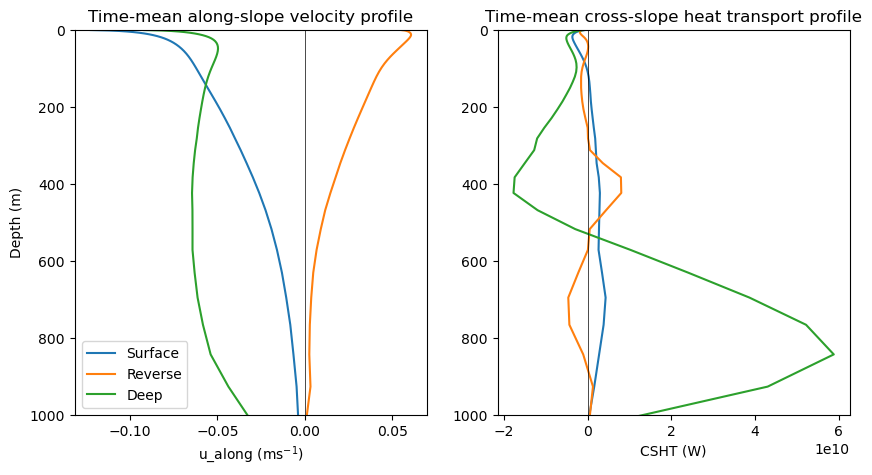

In [11]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
masked_u_along.isel(regime=0).mean('lon').mean('time').plot(y='depth', label=classes[0])
masked_u_along.isel(regime=1).mean('lon').mean('time').plot(y='depth', label=classes[1])
masked_u_along.isel(regime=2).mean('lon').mean('time').plot(y='depth', label=classes[2])
plt.legend()
plt.ylim(1000, 0)
plt.title('Time-mean along-slope velocity profile')
plt.xlabel('u_along (ms$^{-1}$)')
plt.ylabel('Depth (m)')
plt.axvline(0, linewidth=0.5, color='k')

plt.subplot(122)
masked_CSHT.isel(regime=0).mean('lon').mean('time').plot(y='depth', label=classes[0])
masked_CSHT.isel(regime=1).mean('lon').mean('time').plot(y='depth', label=classes[1])
masked_CSHT.isel(regime=2).mean('lon').mean('time').plot(y='depth', label=classes[2])
plt.ylim(1000, 0)
plt.title('Time-mean cross-slope heat transport profile')
plt.xlabel('CSHT (W)')
plt.ylabel('')
plt.axvline(0, linewidth=0.5, color='k');

### Select different sub-regimes

In [ ]:
# Eye-ball the regime boundaries, exclude any time-varying smaller "different" regimes in that sector

# SURFACE
# PR_WS: -33, 56
# AS_RS: -117, -192
# RS_AD: -192, -210
# AD_PR: 72, -229

# DEEP
# Prydz: 56, 72
# Weddell: -33, -58
# Ross: -176, -192
# Adelie: -210, -229

# REVERSE (only one, no need to separate into subregimes)

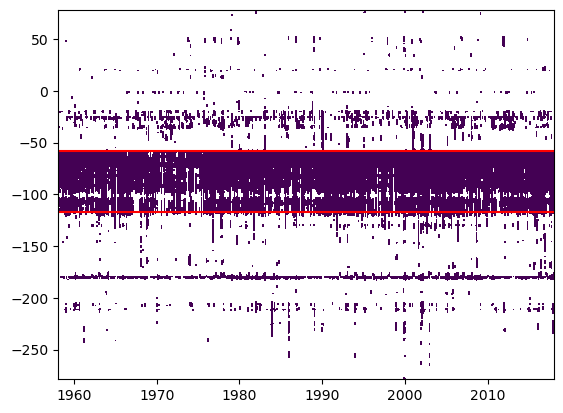

In [82]:
# Reversed
tt = 720
plt.pcolor(clustering_mask.time[:tt],  clustering_mask.lon.values, np.array(clustering_mask[1,:tt,:]).T)
plt.axhline(-58, color='r')
plt.axhline(-117, color='r')

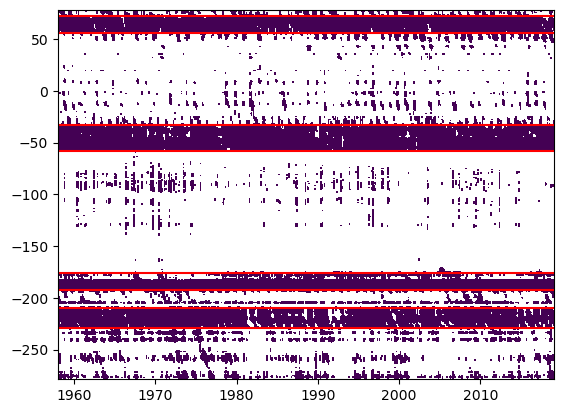

In [36]:
# Bottom
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(clustering_mask[2,...]).T)

plt.axhline(56, color='r')
plt.axhline(72, color='r')

plt.axhline(-33, color='r')
plt.axhline(-58, color='r')

plt.axhline(-176, color='r')
plt.axhline(-192, color='r')

# plt.ylim(-150, -200)

plt.axhline(-210, color='r')
plt.axhline(-229, color='r')

Select mask per region

In [10]:
mask_sfc_PR_WD = clustering_mask.where((clustering_mask.lon > -33) & (clustering_mask.lon < 56))
mask_sfc_AS_RS = clustering_mask.where((clustering_mask.lon < -117) & (clustering_mask.lon > -192))
mask_sfc_RS_AD = clustering_mask.where((clustering_mask.lon < -192) & (clustering_mask.lon > -210))
mask_sfc_AD_PR = clustering_mask.where((clustering_mask.lon < -229) | (clustering_mask.lon > 72))

mask_deep_PR = clustering_mask.where((clustering_mask.lon > 56) & (clustering_mask.lon < 72))
mask_deep_WD = clustering_mask.where((clustering_mask.lon < -33) & (clustering_mask.lon > -58))
mask_deep_RS = clustering_mask.where((clustering_mask.lon < -176) & (clustering_mask.lon > -192))
mask_deep_AD = clustering_mask.where((clustering_mask.lon < -210) & (clustering_mask.lon > -229))

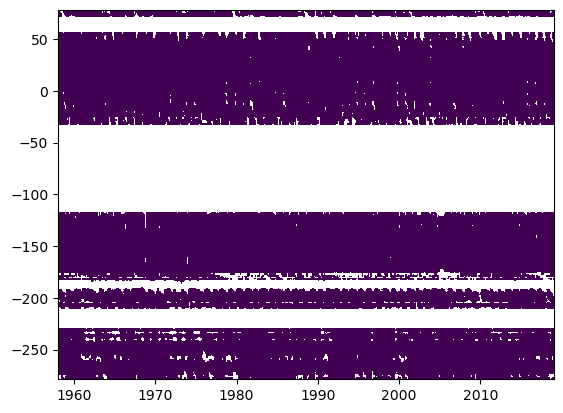

In [13]:
# Surface
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(mask_sfc_PR_WD[0,...]).T)
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(mask_sfc_AS_RS[0,...]).T)
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(mask_sfc_RS_AD[0,...]).T)
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(mask_sfc_AD_PR[0,...]).T);

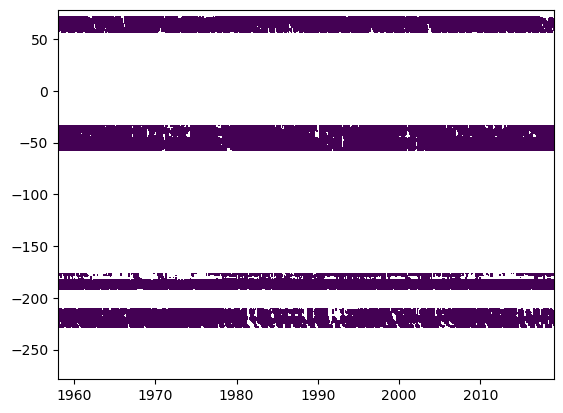

In [14]:
# Deep
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(mask_deep_PR[2,...]).T)
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(mask_deep_WD[2,...]).T)
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(mask_deep_RS[2,...]).T)
plt.pcolor(clustering_mask.time,  clustering_mask.lon.values, np.array(mask_deep_AD[2,...]).T);

Apply masks to u_along and CSHT

Surface

In [11]:
masked_u_along_sfc_PR_WD = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mask_sfc_PR_WD
masked_u_along_sfc_PR_WD.load();

masked_u_along_sfc_AS_RS = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mask_sfc_AS_RS
masked_u_along_sfc_AS_RS.load();

masked_u_along_sfc_RS_AD = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mask_sfc_RS_AD
masked_u_along_sfc_RS_AD.load();

masked_u_along_sfc_AD_PR = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mask_sfc_AD_PR
masked_u_along_sfc_AD_PR.load();

In [12]:
masked_CSHT_sfc_PR_WD = CSHT_months*mask_sfc_PR_WD
masked_CSHT_sfc_PR_WD.load();

masked_CSHT_sfc_AS_RS = CSHT_months*mask_sfc_AS_RS
masked_CSHT_sfc_AS_RS.load();

masked_CSHT_sfc_RS_AD = CSHT_months*mask_sfc_RS_AD
masked_CSHT_sfc_RS_AD.load();

masked_CSHT_sfc_AD_PR = CSHT_months*mask_sfc_AD_PR
masked_CSHT_sfc_AD_PR.load();

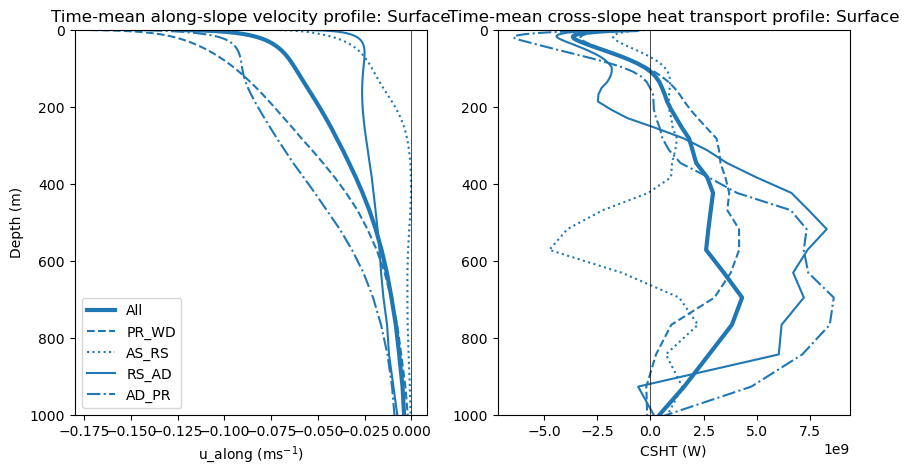

In [20]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
masked_u_along.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='All', linewidth=3)
masked_u_along_sfc_PR_WD.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='PR_WD', color='C0', linestyle='--')
masked_u_along_sfc_AS_RS.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='AS_RS', color='C0', linestyle=':')
masked_u_along_sfc_RS_AD.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='RS_AD', color='C0', linestyle='-')
masked_u_along_sfc_AD_PR.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='AD_PR', color='C0', linestyle='-.')
plt.legend()
plt.ylim(1000, 0)
plt.title('Time-mean along-slope velocity profile: Surface')
plt.xlabel('u_along (ms$^{-1}$)')
plt.ylabel('Depth (m)')
plt.axvline(0, linewidth=0.5, color='k')

plt.subplot(122)
masked_CSHT.isel(regime=0).mean('lon').mean('time').plot(y='depth', linewidth=3)
masked_CSHT_sfc_PR_WD.isel(regime=0).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='--')
masked_CSHT_sfc_AS_RS.isel(regime=0).mean('lon').mean('time').plot(y='depth', color='C0', linestyle=':')
masked_CSHT_sfc_RS_AD.isel(regime=0).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='-')
masked_CSHT_sfc_AD_PR.isel(regime=0).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='-.')
plt.ylim(1000, 0)
plt.title('Time-mean cross-slope heat transport profile: Surface')
plt.xlabel('CSHT (W)')
plt.ylabel('')
plt.axvline(0, linewidth=0.5, color='k');

Deep

In [13]:
masked_u_along_deep_PR = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mask_deep_PR
masked_u_along_deep_PR.load();

masked_u_along_deep_WD = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mask_deep_WD
masked_u_along_deep_WD.load();

masked_u_along_deep_RS = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mask_deep_RS
masked_u_along_deep_RS.load();

masked_u_along_deep_AD = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mask_deep_AD
masked_u_along_deep_AD.load();

In [14]:
masked_CSHT_deep_PR = CSHT_months*mask_deep_PR
masked_CSHT_deep_PR.load();

masked_CSHT_deep_WD = CSHT_months*mask_deep_WD
masked_CSHT_deep_WD.load();

masked_CSHT_deep_RS = CSHT_months*mask_deep_RS
masked_CSHT_deep_RS.load();

masked_CSHT_deep_AD = CSHT_months*mask_deep_AD
masked_CSHT_deep_AD.load();

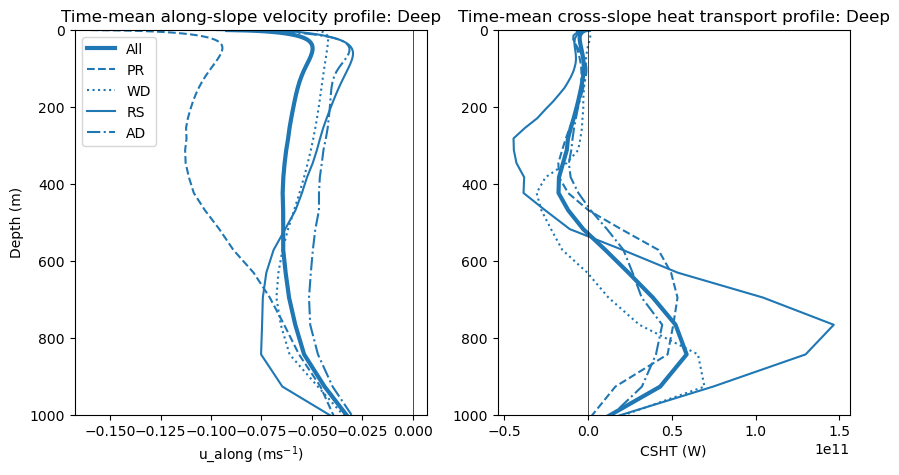

In [23]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
masked_u_along.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='All', linewidth=3)
masked_u_along_deep_PR.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='PR', color='C0', linestyle='--')
masked_u_along_deep_WD.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='WD', color='C0', linestyle=':')
masked_u_along_deep_RS.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='RS', color='C0', linestyle='-')
masked_u_along_deep_AD.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='AD', color='C0', linestyle='-.')
plt.legend()
plt.ylim(1000, 0)
plt.title('Time-mean along-slope velocity profile: Deep')
plt.xlabel('u_along (ms$^{-1}$)')
plt.ylabel('Depth (m)')
plt.axvline(0, linewidth=0.5, color='k')

plt.subplot(122)
masked_CSHT.isel(regime=2).mean('lon').mean('time').plot(y='depth', linewidth=3)
masked_CSHT_deep_PR.isel(regime=2).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='--')
masked_CSHT_deep_WD.isel(regime=2).mean('lon').mean('time').plot(y='depth', color='C0', linestyle=':')
masked_CSHT_deep_RS.isel(regime=2).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='-')
masked_CSHT_deep_AD.isel(regime=2).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='-.')
plt.ylim(1000, 0)
plt.title('Time-mean cross-slope heat transport profile: Deep')
plt.xlabel('CSHT (W)')
plt.ylabel('')
plt.axvline(0, linewidth=0.5, color='k');

All together

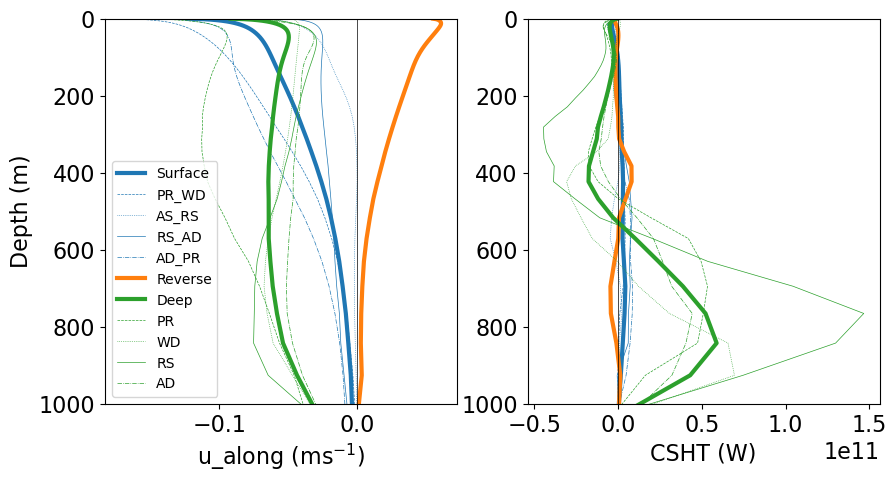

In [34]:
fig = plt.figure(figsize=(10,5))

plt.subplot(121)
masked_u_along.isel(regime=0).mean('lon').mean('time').plot(y='depth', label=classes[0], linewidth=3)
masked_u_along_sfc_PR_WD.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='PR_WD', color='C0', linestyle='--', linewidth=0.5)
masked_u_along_sfc_AS_RS.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='AS_RS', color='C0', linestyle=':', linewidth=0.5)
masked_u_along_sfc_RS_AD.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='RS_AD', color='C0', linestyle='-', linewidth=0.5)
masked_u_along_sfc_AD_PR.isel(regime=0).mean('lon').mean('time').plot(y='depth', label='AD_PR', color='C0', linestyle='-.', linewidth=0.5)
masked_u_along.isel(regime=1).mean('lon').mean('time').plot(y='depth', label=classes[1], linewidth=3)
masked_u_along.isel(regime=2).mean('lon').mean('time').plot(y='depth', label=classes[2], linewidth=3)
masked_u_along_deep_PR.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='PR', color='C2', linestyle='--', linewidth=0.5)
masked_u_along_deep_WD.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='WD', color='C2', linestyle=':', linewidth=0.5)
masked_u_along_deep_RS.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='RS', color='C2', linestyle='-', linewidth=0.5)
masked_u_along_deep_AD.isel(regime=2).mean('lon').mean('time').plot(y='depth', label='AD', color='C2', linestyle='-.', linewidth=0.5)
plt.legend(fontsize=10)
plt.ylim(1000, 0)
plt.title('')#('Time-mean along-slope velocity profile')
plt.xlabel('u_along (ms$^{-1}$)')
plt.ylabel('Depth (m)')
plt.axvline(0, linewidth=0.5, color='k')

plt.subplot(122)
masked_CSHT.isel(regime=0).mean('lon').mean('time').plot(y='depth', label=classes[0], linewidth=3)
masked_CSHT_sfc_PR_WD.isel(regime=0).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='--', linewidth=0.5)
masked_CSHT_sfc_AS_RS.isel(regime=0).mean('lon').mean('time').plot(y='depth', color='C0', linestyle=':', linewidth=0.5)
masked_CSHT_sfc_RS_AD.isel(regime=0).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='-', linewidth=0.5)
masked_CSHT_sfc_AD_PR.isel(regime=0).mean('lon').mean('time').plot(y='depth', color='C0', linestyle='-.', linewidth=0.5)
masked_CSHT.isel(regime=1).mean('lon').mean('time').plot(y='depth', label=classes[1], linewidth=3)
masked_CSHT.isel(regime=2).mean('lon').mean('time').plot(y='depth', label=classes[2], linewidth=3)
masked_CSHT_deep_PR.isel(regime=2).mean('lon').mean('time').plot(y='depth', color='C2', linestyle='--', linewidth=0.5)
masked_CSHT_deep_WD.isel(regime=2).mean('lon').mean('time').plot(y='depth', color='C2', linestyle=':', linewidth=0.5)
masked_CSHT_deep_RS.isel(regime=2).mean('lon').mean('time').plot(y='depth', color='C2', linestyle='-', linewidth=0.5)
masked_CSHT_deep_AD.isel(regime=2).mean('lon').mean('time').plot(y='depth', color='C2', linestyle='-.', linewidth=0.5)
plt.ylim(1000, 0)
plt.title('')#'Time-mean cross-slope heat transport profile')
plt.xlabel('CSHT (W)')
plt.ylabel('')
plt.axvline(0, linewidth=0.5, color='k')

save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'Fig_time_mean_u_csht_subregimes.png');

Monthly climatology (depth average)

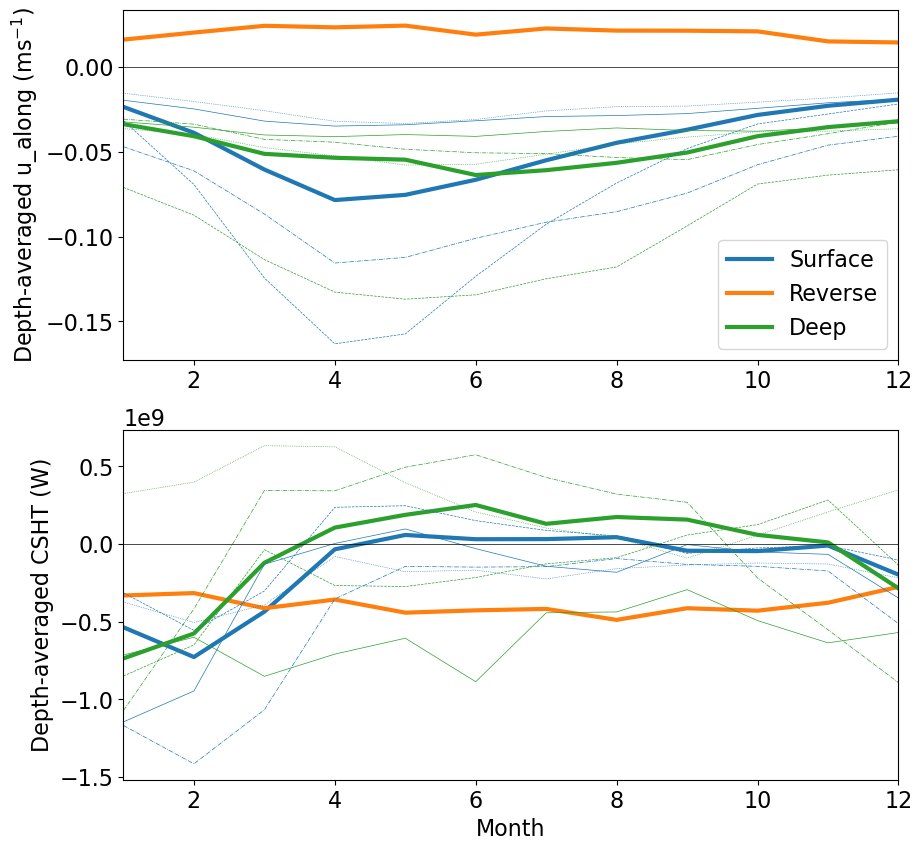

In [32]:
fig = plt.figure(figsize=(10,10))

plt.subplot(211)
masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(label=classes[0], linewidth=3)
masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth').plot(label=classes[1], linewidth=3)
masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(label=classes[2], linewidth=3)
plt.legend()
masked_u_along_sfc_PR_WD.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(c='C0', linestyle='--', linewidth=0.5)
masked_u_along_sfc_AS_RS.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(c='C0', linestyle=':', linewidth=0.5)
masked_u_along_sfc_RS_AD.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(c='C0', linestyle='-', linewidth=0.5)
masked_u_along_sfc_AD_PR.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(c='C0', linestyle='-.', linewidth=0.5)
masked_u_along_deep_PR.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(c='C2', linestyle='--', linewidth=0.5)
masked_u_along_deep_WD.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(c='C2', linestyle=':', linewidth=0.5)
masked_u_along_deep_RS.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(c='C2', linestyle='-', linewidth=0.5)
masked_u_along_deep_AD.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(c='C2', linestyle='-.', linewidth=0.5)
plt.axhline(0, c='k', linewidth=0.5)
plt.title('')
plt.xlabel('')
plt.ylabel('Depth-averaged u_along (ms$^{-1}$)')
plt.xlim(1, 12)

plt.subplot(212)
masked_CSHT.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(label=classes[0], linewidth=3)
masked_CSHT.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth').plot(label=classes[1], linewidth=3)
masked_CSHT.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(label=classes[2], linewidth=3)
masked_CSHT_sfc_PR_WD.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(c='C0', linestyle='--', linewidth=0.5)
masked_CSHT_sfc_AS_RS.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(c='C0', linestyle=':', linewidth=0.5)
masked_CSHT_sfc_RS_AD.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(c='C0', linestyle='-', linewidth=0.5)
masked_CSHT_sfc_AD_PR.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').plot(c='C0', linestyle='-.', linewidth=0.5)
masked_CSHT_deep_PR.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(c='C2', linestyle='--', linewidth=0.5)
masked_CSHT_deep_WD.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(c='C2', linestyle=':', linewidth=0.5)
masked_CSHT_deep_RS.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(c='C2', linestyle='-', linewidth=0.5)
masked_CSHT_deep_AD.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').plot(c='C2', linestyle='-.', linewidth=0.5)
plt.axhline(0, c='k', linewidth=0.5)
plt.title('')
plt.xlabel('Month')
plt.ylabel('Depth-averaged CSHT (W)')
plt.xlim(1, 12);

save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'Fig_depth_mean_u_csht_subregimes.png')

### Correlation between u_along and CSHT

Let's only do monthly to start with.

In [22]:
# Start with taking lon mean

# Total
u_along_layerwise = masked_u_along.mean('lon')
CSHT_layerwise    = masked_CSHT.mean('lon')

# Subregimes
# Surface
u_along_layerwise_sfc_PR_WD = masked_u_along_sfc_PR_WD.mean('lon')
u_along_layerwise_sfc_AS_RS = masked_u_along_sfc_AS_RS.mean('lon')
u_along_layerwise_sfc_RS_AD = masked_u_along_sfc_RS_AD.mean('lon')
u_along_layerwise_sfc_AD_PR = masked_u_along_sfc_AD_PR.mean('lon')

CSHT_layerwise_sfc_PR_WD = masked_CSHT_sfc_PR_WD.mean('lon')
CSHT_layerwise_sfc_AS_RS = masked_CSHT_sfc_AS_RS.mean('lon')
CSHT_layerwise_sfc_RS_AD = masked_CSHT_sfc_RS_AD.mean('lon')
CSHT_layerwise_sfc_AD_PR = masked_CSHT_sfc_AD_PR.mean('lon')

# Deep
u_along_layerwise_deep_PR = masked_u_along_deep_PR.mean('lon')
u_along_layerwise_deep_WD = masked_u_along_deep_WD.mean('lon')
u_along_layerwise_deep_RS = masked_u_along_deep_RS.mean('lon')
u_along_layerwise_deep_AD = masked_u_along_deep_AD.mean('lon')

CSHT_layerwise_deep_PR = masked_CSHT_deep_PR.mean('lon')
CSHT_layerwise_deep_WD = masked_CSHT_deep_WD.mean('lon')
CSHT_layerwise_deep_RS = masked_CSHT_deep_RS.mean('lon')
CSHT_layerwise_deep_AD = masked_CSHT_deep_AD.mean('lon')


Total

In [16]:
slope_all  = np.zeros((masked_u_along.depth.size, 3))
stderr_all = np.zeros((masked_u_along.depth.size, 3))
r_sq_all   = np.zeros((masked_u_along.depth.size, 3))

for i in range(3):
    for j in range(masked_u_along.depth.size):
        slope_all[j,i]  = stats.linregress(u_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
        stderr_all[j,i] = stats.linregress(u_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
        r_sq_all[j,i]   = stats.linregress(u_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2


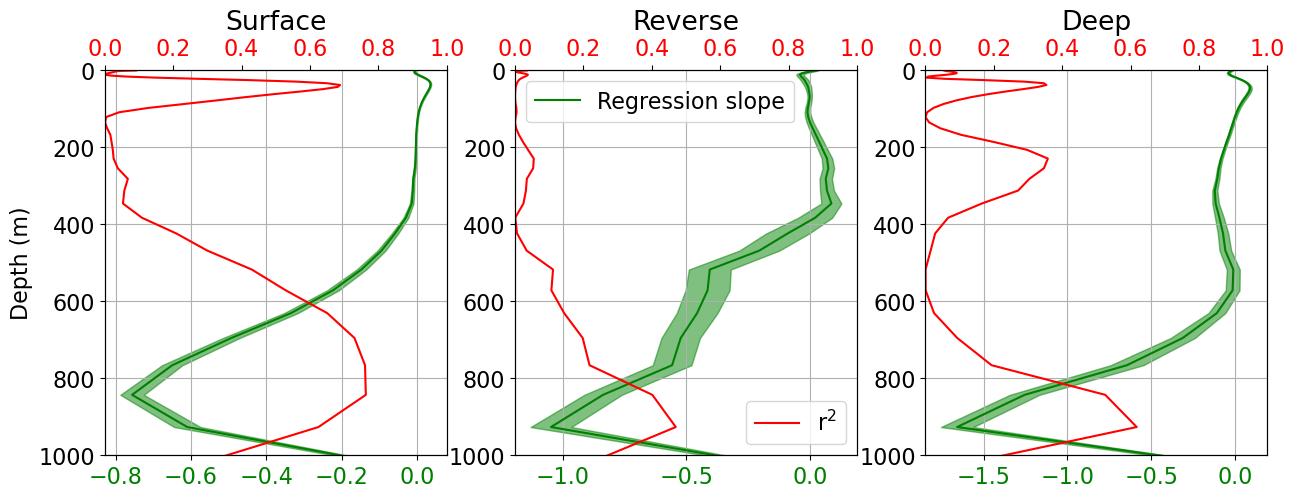

In [47]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs = axs.ravel()

for i in range(3):
    axs[i].plot(slope_all[:,i], masked_u_along.depth, color='green', label='Regression slope')
    if i == 1:
        axs[i].legend()
    axs[i].fill_betweenx(masked_u_along.depth,  slope_all[:,i]-stderr_all[:,i]*2, slope_all[:,i]+stderr_all[:,i]*2, alpha=0.5, color='green')
    axs[i].tick_params(axis='x', labelcolor='green')
    
    axs[i].set_title(classes[i])
    ax1 = axs[i].twiny()
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_all[:,i], masked_u_along.depth, 'r', label='r$^2$')
    if i == 1:
        plt.legend(loc=4)
    plt.xlabel('')
    ax1.tick_params(axis='x', labelcolor='r')

    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    axs[i].grid()

    axs[0].set_ylabel('Depth (m)')

save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'Fig_CSHT_vs_u_along_monthly.png')
    

Subregimes - Surface

In [45]:
slope_sfc  = np.zeros((masked_u_along.depth.size, 4))
stderr_sfc = np.zeros((masked_u_along.depth.size, 4))
r_sq_sfc   = np.zeros((masked_u_along.depth.size, 4))

i = 0
for j in range(masked_u_along.depth.size):
    slope_sfc[j,0]  = stats.linregress(u_along_layerwise_sfc_PR_WD[:,j,i][~np.isnan(CSHT_layerwise_sfc_PR_WD[:,j,i])], CSHT_layerwise_sfc_PR_WD[:,j,i][~np.isnan(CSHT_layerwise_sfc_PR_WD[:,j,i])]/1e12).slope
    stderr_sfc[j,0] = stats.linregress(u_along_layerwise_sfc_PR_WD[:,j,i][~np.isnan(CSHT_layerwise_sfc_PR_WD[:,j,i])], CSHT_layerwise_sfc_PR_WD[:,j,i][~np.isnan(CSHT_layerwise_sfc_PR_WD[:,j,i])]/1e12).stderr
    r_sq_sfc[j,0]   = stats.linregress(u_along_layerwise_sfc_PR_WD[:,j,i][~np.isnan(CSHT_layerwise_sfc_PR_WD[:,j,i])], CSHT_layerwise_sfc_PR_WD[:,j,i][~np.isnan(CSHT_layerwise_sfc_PR_WD[:,j,i])]/1e12).rvalue**2

    slope_sfc[j,1]  = stats.linregress(u_along_layerwise_sfc_AS_RS[:,j,i][~np.isnan(CSHT_layerwise_sfc_AS_RS[:,j,i])], CSHT_layerwise_sfc_AS_RS[:,j,i][~np.isnan(CSHT_layerwise_sfc_AS_RS[:,j,i])]/1e12).slope
    stderr_sfc[j,1] = stats.linregress(u_along_layerwise_sfc_AS_RS[:,j,i][~np.isnan(CSHT_layerwise_sfc_AS_RS[:,j,i])], CSHT_layerwise_sfc_AS_RS[:,j,i][~np.isnan(CSHT_layerwise_sfc_AS_RS[:,j,i])]/1e12).stderr
    r_sq_sfc[j,1]   = stats.linregress(u_along_layerwise_sfc_AS_RS[:,j,i][~np.isnan(CSHT_layerwise_sfc_AS_RS[:,j,i])], CSHT_layerwise_sfc_AS_RS[:,j,i][~np.isnan(CSHT_layerwise_sfc_AS_RS[:,j,i])]/1e12).rvalue**2

    slope_sfc[j,2]  = stats.linregress(u_along_layerwise_sfc_RS_AD[:,j,i][~np.isnan(CSHT_layerwise_sfc_RS_AD[:,j,i])], CSHT_layerwise_sfc_RS_AD[:,j,i][~np.isnan(CSHT_layerwise_sfc_RS_AD[:,j,i])]/1e12).slope
    stderr_sfc[j,2] = stats.linregress(u_along_layerwise_sfc_RS_AD[:,j,i][~np.isnan(CSHT_layerwise_sfc_RS_AD[:,j,i])], CSHT_layerwise_sfc_RS_AD[:,j,i][~np.isnan(CSHT_layerwise_sfc_RS_AD[:,j,i])]/1e12).stderr
    r_sq_sfc[j,2]   = stats.linregress(u_along_layerwise_sfc_RS_AD[:,j,i][~np.isnan(CSHT_layerwise_sfc_RS_AD[:,j,i])], CSHT_layerwise_sfc_RS_AD[:,j,i][~np.isnan(CSHT_layerwise_sfc_RS_AD[:,j,i])]/1e12).rvalue**2

    slope_sfc[j,3]  = stats.linregress(u_along_layerwise_sfc_AD_PR[:,j,i][~np.isnan(CSHT_layerwise_sfc_AD_PR[:,j,i])], CSHT_layerwise_sfc_AD_PR[:,j,i][~np.isnan(CSHT_layerwise_sfc_AD_PR[:,j,i])]/1e12).slope
    stderr_sfc[j,3] = stats.linregress(u_along_layerwise_sfc_AD_PR[:,j,i][~np.isnan(CSHT_layerwise_sfc_AD_PR[:,j,i])], CSHT_layerwise_sfc_AD_PR[:,j,i][~np.isnan(CSHT_layerwise_sfc_AD_PR[:,j,i])]/1e12).stderr
    r_sq_sfc[j,3]   = stats.linregress(u_along_layerwise_sfc_AD_PR[:,j,i][~np.isnan(CSHT_layerwise_sfc_AD_PR[:,j,i])], CSHT_layerwise_sfc_AD_PR[:,j,i][~np.isnan(CSHT_layerwise_sfc_AD_PR[:,j,i])]/1e12).rvalue**2


Subregimes - Deep

In [36]:
slope_deep  = np.zeros((masked_u_along.depth.size, 4))
stderr_deep = np.zeros((masked_u_along.depth.size, 4))
r_sq_deep   = np.zeros((masked_u_along.depth.size, 4))

i = 2
for j in range(masked_u_along.depth.size):
    slope_deep[j,0]  = stats.linregress(u_along_layerwise_deep_PR[:,j,i][~np.isnan(CSHT_layerwise_deep_PR[:,j,i])], CSHT_layerwise_deep_PR[:,j,i][~np.isnan(CSHT_layerwise_deep_PR[:,j,i])]/1e12).slope
    stderr_deep[j,0] = stats.linregress(u_along_layerwise_deep_PR[:,j,i][~np.isnan(CSHT_layerwise_deep_PR[:,j,i])], CSHT_layerwise_deep_PR[:,j,i][~np.isnan(CSHT_layerwise_deep_PR[:,j,i])]/1e12).stderr
    r_sq_deep[j,0]   = stats.linregress(u_along_layerwise_deep_PR[:,j,i][~np.isnan(CSHT_layerwise_deep_PR[:,j,i])], CSHT_layerwise_deep_PR[:,j,i][~np.isnan(CSHT_layerwise_deep_PR[:,j,i])]/1e12).rvalue**2
    
    slope_deep[j,1]  = stats.linregress(u_along_layerwise_deep_WD[:,j,i][~np.isnan(CSHT_layerwise_deep_WD[:,j,i])], CSHT_layerwise_deep_WD[:,j,i][~np.isnan(CSHT_layerwise_deep_WD[:,j,i])]/1e12).slope
    stderr_deep[j,1] = stats.linregress(u_along_layerwise_deep_WD[:,j,i][~np.isnan(CSHT_layerwise_deep_WD[:,j,i])], CSHT_layerwise_deep_WD[:,j,i][~np.isnan(CSHT_layerwise_deep_WD[:,j,i])]/1e12).stderr
    r_sq_deep[j,1]   = stats.linregress(u_along_layerwise_deep_WD[:,j,i][~np.isnan(CSHT_layerwise_deep_WD[:,j,i])], CSHT_layerwise_deep_WD[:,j,i][~np.isnan(CSHT_layerwise_deep_WD[:,j,i])]/1e12).rvalue**2
    
    slope_deep[j,2]  = stats.linregress(u_along_layerwise_deep_RS[:,j,i][~np.isnan(CSHT_layerwise_deep_RS[:,j,i])], CSHT_layerwise_deep_RS[:,j,i][~np.isnan(CSHT_layerwise_deep_RS[:,j,i])]/1e12).slope
    stderr_deep[j,2] = stats.linregress(u_along_layerwise_deep_RS[:,j,i][~np.isnan(CSHT_layerwise_deep_RS[:,j,i])], CSHT_layerwise_deep_RS[:,j,i][~np.isnan(CSHT_layerwise_deep_RS[:,j,i])]/1e12).stderr
    r_sq_deep[j,2]   = stats.linregress(u_along_layerwise_deep_RS[:,j,i][~np.isnan(CSHT_layerwise_deep_RS[:,j,i])], CSHT_layerwise_deep_RS[:,j,i][~np.isnan(CSHT_layerwise_deep_RS[:,j,i])]/1e12).rvalue**2
    
    slope_deep[j,3]  = stats.linregress(u_along_layerwise_deep_AD[:,j,i][~np.isnan(CSHT_layerwise_deep_AD[:,j,i])], CSHT_layerwise_deep_AD[:,j,i][~np.isnan(CSHT_layerwise_deep_AD[:,j,i])]/1e12).slope
    stderr_deep[j,3] = stats.linregress(u_along_layerwise_deep_AD[:,j,i][~np.isnan(CSHT_layerwise_deep_AD[:,j,i])], CSHT_layerwise_deep_AD[:,j,i][~np.isnan(CSHT_layerwise_deep_AD[:,j,i])]/1e12).stderr
    r_sq_deep[j,3]   = stats.linregress(u_along_layerwise_deep_AD[:,j,i][~np.isnan(CSHT_layerwise_deep_AD[:,j,i])], CSHT_layerwise_deep_AD[:,j,i][~np.isnan(CSHT_layerwise_deep_AD[:,j,i])]/1e12).rvalue**2


In [49]:
subregime_sfc  = ['PR_WD', 'AS_RS', 'RS_AD', 'AD_PR']
subregime_deep = ['Prydz', 'Weddell', 'Ross', 'Adelie']

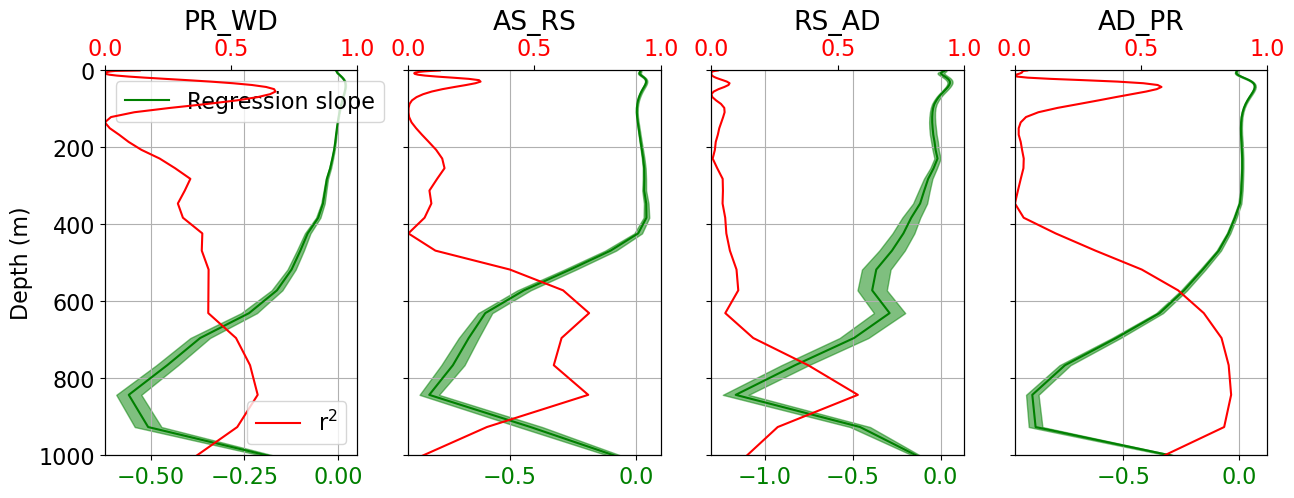

In [51]:
# Surface

fig, axs = plt.subplots(ncols=4, figsize=(15,5))
axs = axs.ravel()

for i in range(4):
    axs[i].plot(slope_sfc[:,i], masked_u_along.depth, color='green', label='Regression slope')
    if i == 0:
        axs[i].legend(loc=2)
    axs[i].fill_betweenx(masked_u_along.depth,  slope_sfc[:,i]-stderr_sfc[:,i]*2, slope_sfc[:,i]+stderr_sfc[:,i]*2, alpha=0.5, color='green')
    axs[i].tick_params(axis='x', labelcolor='green')
    
    axs[i].set_title(subregime_sfc[i])
    ax1 = axs[i].twiny()
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_sfc[:,i], masked_u_along.depth, 'r', label='r$^2$')
    if i == 0:
        plt.legend(loc=4)
    plt.xlabel('')
    ax1.tick_params(axis='x', labelcolor='r')
    if i > 0:
        ax1.tick_params(labelleft=False)
        axs[i].tick_params(labelleft=False)

    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    axs[i].grid()

    axs[0].set_ylabel('Depth (m)')

save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'Fig_CSHT_vs_u_along_monthly_subregimes_sfc.png')
    

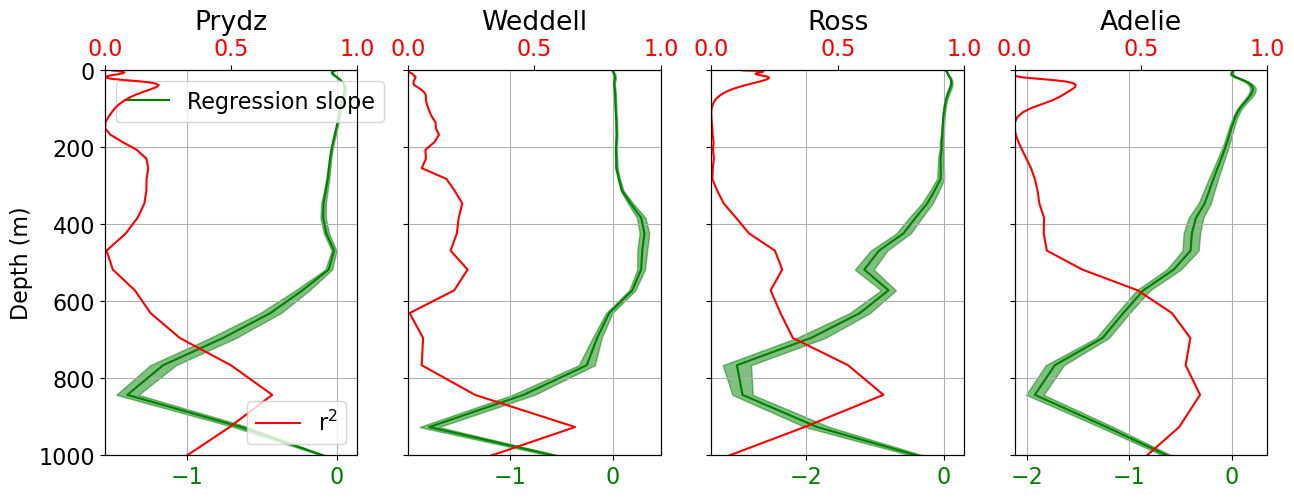

In [52]:
# Deep

fig, axs = plt.subplots(ncols=4, figsize=(15,5))
axs = axs.ravel()

for i in range(4):
    axs[i].plot(slope_deep[:,i], masked_u_along.depth, color='green', label='Regression slope')
    if i == 0:
        axs[i].legend(loc=2)
    axs[i].fill_betweenx(masked_u_along.depth,  slope_deep[:,i]-stderr_deep[:,i]*2, slope_deep[:,i]+stderr_deep[:,i]*2, alpha=0.5, color='green')
    axs[i].tick_params(axis='x', labelcolor='green')
    
    axs[i].set_title(subregime_deep[i])
    ax1 = axs[i].twiny()
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_deep[:,i], masked_u_along.depth, 'r', label='r$^2$')
    if i == 0:
        plt.legend(loc=4)
    plt.xlabel('')
    ax1.tick_params(axis='x', labelcolor='r')
    if i > 0:
        ax1.tick_params(labelleft=False)
        axs[i].tick_params(labelleft=False)

    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    axs[i].grid()

    axs[0].set_ylabel('Depth (m)')

save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'Fig_CSHT_vs_u_along_monthly_subregimes_deep.png')
    

In [8]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']